In [1]:
import os
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pickle
import torch
import torch.nn as nn

from oit_helpers import DataPreprocessors,LSTM,createDataLoader,getDataLoader

sns.set(style="darkgrid", font_scale=1.5)
%matplotlib inline

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocessing

## 1. Import the data

In [2]:
data_location = './datasets/all-crypto-currencies/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
data = pd.read_csv(data_location, 
                    parse_dates=['Timestamp'],
                    index_col="Timestamp")
no_missing_data = data.dropna(subset=['Close'])
dates = pd.to_datetime(no_missing_data.index, unit='s')
no_missing_data.index = dates
cropped = no_missing_data[no_missing_data.index.year>2016].copy()

## 2. Extract Bitcoin closing prices

In [3]:
bit_close = pd.DataFrame({'Close': cropped.Close.copy()})
bit_close.head(3)

,Close
Timestamp,
2017-01-01 00:01:00,966.34
2017-01-01 00:02:00,966.37
2017-01-01 00:05:00,966.43


In [4]:
bit_close.shape

(2144365, 1)

Text(0.5, 1.0, 'BitCoin Closing Prices')

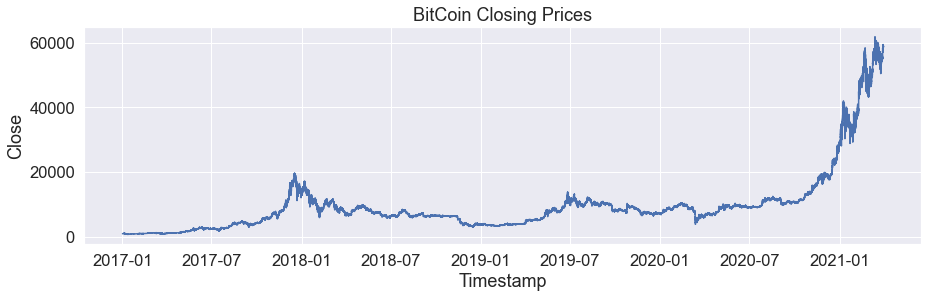

In [5]:
plt.figure(figsize=(15,4))
(sns.lineplot(x=cropped.index, y="Close", data=cropped).set_title("BitCoin Closing Prices"))

## 3. Initialize preprocessor object

In [6]:
# our custom preprocessor class
dprep = DataPreprocessors(data=bit_close)

## 4. Prepare time series data

In [7]:
series_data = dprep.original_data.iloc[:,0] # we need a pandas series for the function
n_lag = 30 # aka the timestep
historical_all,target_all = dprep.create_timeseries_sequences(data=series_data,
                                                              timestep=n_lag)

## 5. Train test split

In [8]:
print(historical_all.shape)
print(target_all.shape)

(2144335, 30)
(2144335,)


Funky way of doing this, but essentially we are creating train/test datasets, then using the training set to further create train/validate datasets. This leads to **three** datasets: training (for training/tuning); validation (for tuning and assessing performance (while training) on data that "haven't been seen"; testing (for final validation).

If you play around with this, careful not to make the training set too small. Validation and testing can be smaller, but also shouldn't be too small. Read up on this, or experiment.

In [9]:
historical_train, historical_test, target_train, target_test = (dprep
                                                                .train_test_split(historical=historical_all, 
                                                                                  target=target_all, 
                                                                                  prop_train=.98,
                                                                                  valid_set=False))
print(historical_train.shape)
print(historical_test.shape)
print(target_train.shape)
print(target_test.shape)

Training set has shape (2101448, 30)
Test set has shape (42887, 30)
(2101448, 30)
(42887, 30)
(2101448,)
(42887,)


In [10]:
historical_train, historical_val, target_train, target_val = (dprep
                                                                .train_test_split(historical=historical_train, 
                                                                                  target=target_train, 
                                                                                  prop_train=.75,
                                                                                  valid_set=True))

Training set has shape (1576086, 30)
Validation set has shape (525362, 30)


## 6. Normalize the data

I added a `normalize_data` method. Look at it closely and make sure you understand what's going on. Important: Remember that you don't want to mix information from the training into/from validation/testing data. Scaling data technically gathers information about the data that's being scaled so there's a proper way of doing this:

- Gather information from the training data needed for scaling, and transform it
- Use that information to also transform the validation/testing data
- Note: We're not gathering information from validation/testing data

The transformers we use from `scikit-learn` offer intuitive methods to do this: 
- `fit_transform()` for the training data
- `transform()` for validation/testing data

Make sure you see how this mechanism is working within the `normalize_data` method I wrote, and how it's being used in the cell below.

In [20]:
# Use the historical training set to create the scaler and normalize the data to be between 0 and 1
historical_train, scaler_ = dprep.normalize_data(historical_train, train = True)
# Normalize the validation set and the testing set
historical_val, _ = dprep.normalize_data(historical_val, scaler_)
historical_test, _ = dprep.normalize_data(historical_test, scaler_) 

# Data Modeling

## 1. Create dataloaders for training and test sets

One good practice when using PyTorch is to make use of their `DataLoader` class object. Read about it [here](https://www.geeksforgeeks.org/how-to-use-a-dataloader-in-pytorch/), but simply put...it's a custom class that organizes the data input we feed to torch models, and makes working with big data much more efficient in terms of time and memory.

`params` is a dictionary that holds parameters used by the DataLoader object. I've added one (which is simply the default value as an example), but take a look [here](https://pytorch.org/docs/stable/data.html) to see a list of options that you can play around with. Get curious!

Follow the trail and see how these parameters impact how PyTorch works with the data/model.

In [34]:
# Play around with these params
params = {'batch_size':5}

In [35]:
training_generator = getDataLoader(historical_train, target_train, params)
test_generator = getDataLoader(historical_val, target_val, params)

## 2. Initialize the model

In [41]:
hidden_layer_size = 100
n_layers = 1
output_size = 1
dropout = 0 #default
device = "cpu" #only option, unless you have a fancy GPU

model = LSTM(input_size = n_lag, 
             hidden_layer_size = hidden_layer_size, 
             output_size = output_size,
             n_layers = n_layers,
             do = dropout).to(device)

## 3. Define the loss function and optimizer

There are DOZENS of hyperparameters that we can tune in neural networks. Play around with these and try to see how they impact performance.

In [42]:
# hyperparameters
learning_rate = 1e-3
n_epochs = 200

In [43]:
# using the mean squred error loss function. 
loss_fn = nn.MSELoss()
# 
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 4. Train the model

Note that what we're collecting in the lists below aren't the MSE values, but calculated RMSE values instead. Make sure you read about these two and how they are related. Just note that we're using MSE as the loss function, but simply collection RMSE for reporting purposes. Why? Because compared to MSE, RMSE is *in the same scale as the raw data*. Thus, you can interpret error in terms of dollar amounts.

In [46]:
# Track the losses across epochs
train_losses = []
valid_losses = []

In [45]:
%%time
# Training loop over epochs
for epoch in range(1, n_epochs + 1):
    # loss at the start of each epoch. Both training and validation starts at 0.
    ls = 0
    valid_ls = 0
    # Train for one epoch
    for xb, yb in training_generator:
        # Perform the forward pass
        # The pytorch.unsqueeze function adds a new dimension of size 1 to the tensor.
        ips = xb.unsqueeze(0)
        targs = yb
        # feed the inputs into the model and get the outputs. We are doing a forward pass
        op = model(ips)

        # Backpropagate the errors through the network
        optim.zero_grad()
        loss = loss_fn(op, targs)
        loss.backward()
        # the next step in the optimization function
        optim.step()
        # the cost function, which is just the average of the loss of all the tensors
        ls += (loss.item() / ips.shape[1])
        
    # Check the performance on validation data
    for xb, yb in test_generator:
        ips = xb.unsqueeze(0)
        # use the predict method in the model using input
        ops = model.predict(ips)
        vls = loss_fn(ops, yb)
        valid_ls += (vls.item() / xb.shape[1])

    # Take the square root of the mean square error to see the loss in actual dollar amounts
    rmse = lambda x: round(sqrt(x * 1.000), 3)
    train_losses.append(str(rmse(ls)))
    valid_losses.append(str(rmse(valid_ls)))

    # Print the total loss for every tenth epoch
    if (epoch % 10 == 0) or (epoch == 1):
        print(f"Epoch {str(epoch):<4}/{str(n_epochs):<4} | Train Loss: {train_losses[-1]:<8} | Validation Loss: {valid_losses[-1]:<8}")

RuntimeError: Expected hidden[0] size (1, 5, 100), got [1, 1, 100]

Notes for this week:
    -Experiment with:
        -batch size (speed? performance?)
        -different loss functions
        -different cryptocurrency data
    -Make a graph visualizing the loss / accuracy of predictions.
    -How to make train/test splits for time-series data
        -Right now, the training data has never seen the big spikes near the end.
        